# Using Bureau of Labor Statistics API

Using BLS API, we can obtain information about CPI (consumer price index) or unemployment statistics using some Python scripting.

**References:**
- URL: https://www.bls.gov/
- Developer API: https://www.bls.gov/developers/home.htm
- Registering for the API V2: https://www.bls.gov/developers/api_faqs.htm#register3
- How to add optional parameters like the secret key to the request: https://www.bls.gov/developers/api_signature_v2.htm#parameters
- Complete list of CPI series IDs: https://download.bls.gov/pub/time.series/cu/cu.series
- Complete list of national unemployment series IDs: https://download.bls.gov/pub/time.series/ln/ln.series
- Complete list of current employment statistics (CES) series IDs: https://download.bls.gov/pub/time.series/ce/ce.series

**Popular series ID:**
- LNS14000000: National unemployment rate - seasonally adjusted
- CUSR0000SA0: All items in U.S. city average, all urban consumers, seasonally adjusted
- CUSR0000SETA: New and used motor vehicles in U.S. city average, all urban consumers, seasonally adjusted
- CUSR0000SETA01: New vehicles in U.S. city average, all urban consumers, seasonally adjusted
- CUSR0000SETA02: Used cars and trucks in U.S. city average, all urban consumers, seasonally adjusted
- CUSR0000SAF: Food and beverages in U.S. city average, all urban consumers, seasonally adjusted
- CUSR0000SACL1E4: Commodities less food, energy, and used cars and trucks in U.S. city average, all urban consumers, seasonally adjusted
- CUSR0000SACE: Energy commodities in U.S. city average, all urban consumers, seasonally adjusted
- CUSR0000SS47014: Gasoline, unleaded regular in U.S. city average, all urban consumers, seasonally adjusted
- CUSR0000SAH: Housing in U.S. city average, all urban consumers, seasonally adjusted

In [1]:
from datetime import date
from dateutil.relativedelta import relativedelta
from pathlib import Path
import configparser
import json
import matplotlib.pyplot as plt
import pandas as pd
import requests
import seaborn as sns

In [2]:
config = configparser.ConfigParser()
config.read(Path.home() / '.config' / 'config.ini')
bls_key = config['bls']['secretkey']

In [3]:
def plot_bls_series_id(
    series_id: str, series_descr: str, bls_key: str, past_n_years: int = 19
):
    """
    A function that plots a BLS series

    Parameters
    ----------
    series_id : str
        Series ID
    series_descr : str
        Series description
    bls_key : str
        BLS secret key that you need to obtain from registering here: https://data.bls.gov/registrationEngine/
    past_n_years : int
        Number of years worth of data to be plotted.  By default, will plot last 19 years' worth of data (bls.gov's max)

    Returns
    -------
    A MATPLOTLIB line chart with vertical regions to indicate when recessions have occurred to add historical context
    """

    try:
        current_date = date.today()
        current_year = current_date.year
        start_year = current_year - past_n_years

        # These 2 variables are used to shade the current year region
        previous_month = (current_date - relativedelta(months=1)).strftime("%Y-%m-%d")[:7] + "-01"
        start_of_current_year = str(current_year) + "-01-01"

        headers = {"Content-type": "application/json"}
        data = json.dumps(
            {
                "seriesid": [series_id],
                "startyear": str(start_year),
                "endyear": str(current_year),
                "registrationkey": bls_key,
            }
        )
        p = requests.post(
            "https://api.bls.gov/publicAPI/v2/timeseries/data/",
            data=data,
            headers=headers,
        )
        p.raise_for_status()  # Raise an exception for HTTP errors
        json_data = json.loads(p.text)

        df_list = []
        for series in json_data["Results"]["series"]:
            df = pd.DataFrame.from_dict(series["data"])
            # Transformations:
            # Create series_id column
            # Filter to just periods M01, M02, ..., M12
            # Create year-month column as date data type
            # Cast value column as float data type
            # Keep only series_id, year_month, and value columns
            df = (
                df.assign(series_id=series["seriesID"])
                .query("(period >= 'M01') & (period <= 'M12')")
                .assign(
                    year_month=pd.to_datetime(
                        df["year"].astype("str") + "-" + df["period"].str[-2:],
                        format="%Y-%m",
                    )
                )
                .assign(value=df["value"].astype("float"))
            )[["series_id", "year_month", "value"]]
            df_list.append(df)

        df_final = pd.concat(df_list, axis="columns")

        fig, ax = plt.subplots(figsize=(8, 5))
        sns.lineplot(
            data=df_final,
            x="year_month",
            y="value",
            ax=ax,
        )
        # Created shaded region for current year
        ax.fill_between(
            x=[start_of_current_year, previous_month],
            y1=[int(df_final["value"].max()) + 1, int(df_final["value"].max()) + 1],
            alpha=0.2,
            color="blue",
        )
        ax.set_ylim(int(df_final["value"].min()) - 1, int(df_final["value"].max()) + 1)
        ax.spines[["right", "top"]].set_visible(False)
        plt.xlabel("Year")
        plt.ylabel("Value")
        plt.suptitle(series_descr)

        # If default of past 19 years is chosen, then add recessions and covid pandemic regions
        if past_n_years == 19:
            # Create shaded vertical regions that indicate when recessions and COVID-19 pandemic happened
            # https://en.wikipedia.org/wiki/List_of_recessions_in_the_United_States
            ax.fill_between(
                x=["2001-03-01", "2001-11-01"],
                y1=[int(df_final["value"].max()) + 1, int(df_final["value"].max()) + 1],
                alpha=0.2,
                color="gray",
            )
            ax.fill_between(
                x=["2007-12-01", "2009-06-01"],
                y1=[int(df_final["value"].max()) + 1, int(df_final["value"].max()) + 1],
                alpha=0.2,
                color="gray",
            )
            ax.fill_between(
                x=["2020-02-01", "2020-04-01"],
                y1=[int(df_final["value"].max()) + 1, int(df_final["value"].max()) + 1],
                alpha=0.2,
                color="gray",
            )
            plt.title("grey=recession / blue=current year", fontsize=10)
            plt.tight_layout()
            plt.show()
        # else don't add the recession and covid pandemic regions
        else:
            plt.title("blue=current year", fontsize=10)
            plt.tight_layout()
            plt.show()
    except requests.exceptions.RequestException as e:
        print("An error occurred during the HTTP request:", e)
    except (ValueError, KeyError) as e:
        print("An error occurred while processing the data:", e)

#### National Unemployment Rate

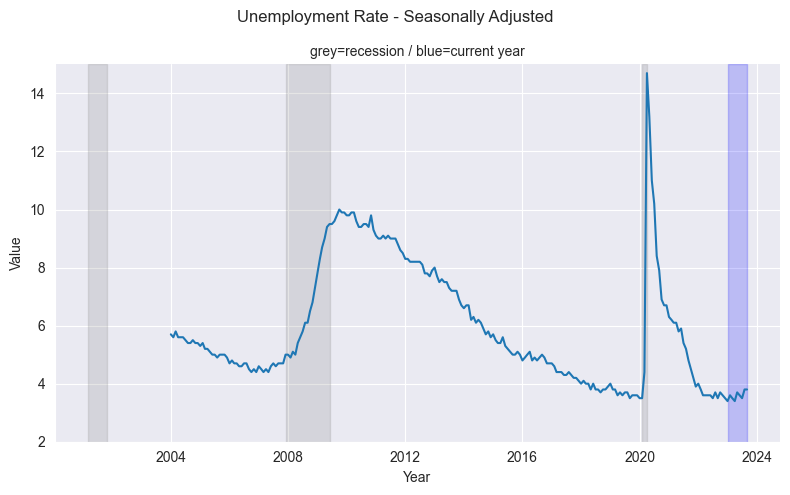

In [4]:
plot_bls_series_id(
    series_id='LNS14000000',
    series_descr='Unemployment Rate - Seasonally Adjusted',
    bls_key=bls_key
)

#### CPI - All Items Seasonally Adjusted

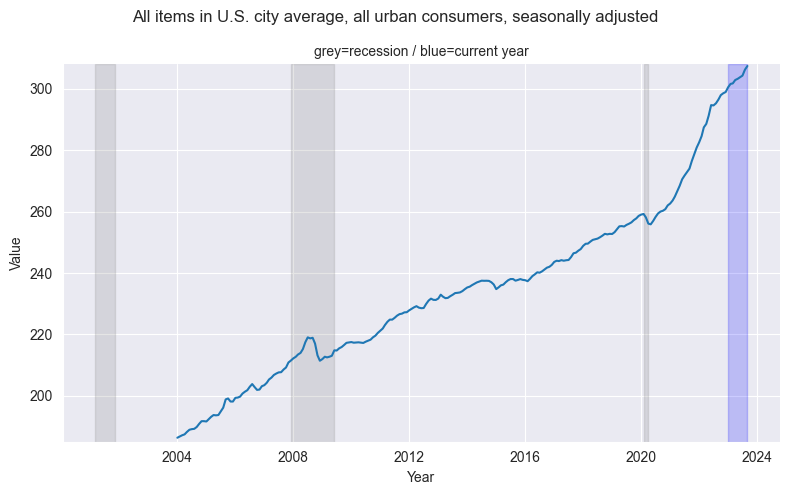

In [5]:
plot_bls_series_id(
    series_id='CUSR0000SA0',
    series_descr='All items in U.S. city average, all urban consumers, seasonally adjusted',
    bls_key=bls_key
)

#### CPI for New and used motor vehicles in U.S. city average, all urban consumers, seasonally adjusted

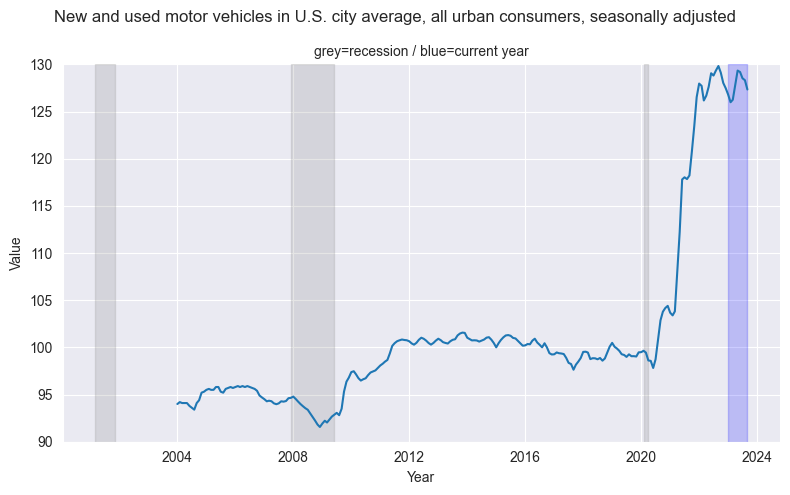

In [6]:
plot_bls_series_id(
    series_id='CUSR0000SETA',
    series_descr='New and used motor vehicles in U.S. city average, all urban consumers, seasonally adjusted',
    bls_key=bls_key
)

#### CPI for New vehicles in U.S. city average, all urban consumers, seasonally adjusted

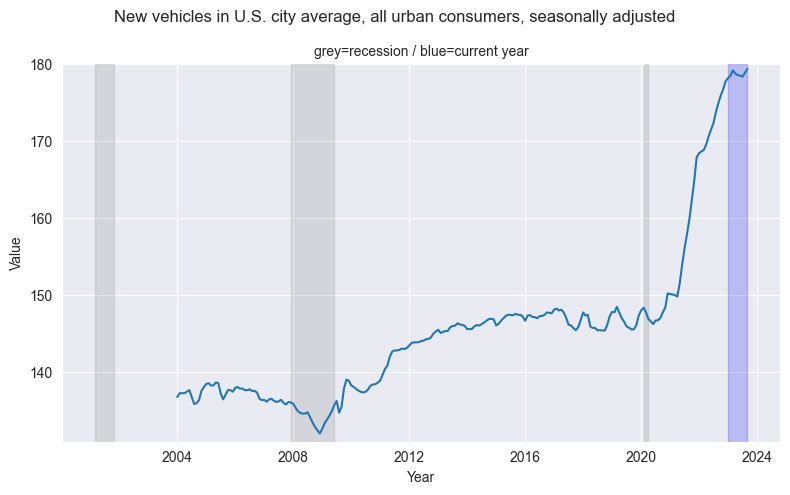

In [7]:
plot_bls_series_id(
    series_id='CUSR0000SETA01',
    series_descr='New vehicles in U.S. city average, all urban consumers, seasonally adjusted',
    bls_key=bls_key
)

Looks like used cars/trucks are the ones actually trending downward, not new cars/trucks.  We'll confirm that next.

#### CPI for Used cars and trucks in U.S. city average, all urban consumers, seasonally adjusted

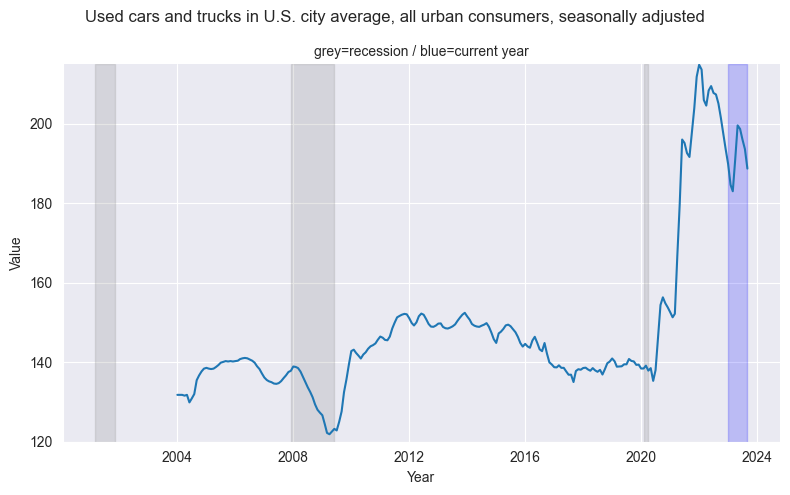

In [8]:
plot_bls_series_id(
    series_id='CUSR0000SETA02',
    series_descr='Used cars and trucks in U.S. city average, all urban consumers, seasonally adjusted',
    bls_key=bls_key
)

#### CPI for Food and beverages in U.S. city average, all urban consumers, seasonally adjusted

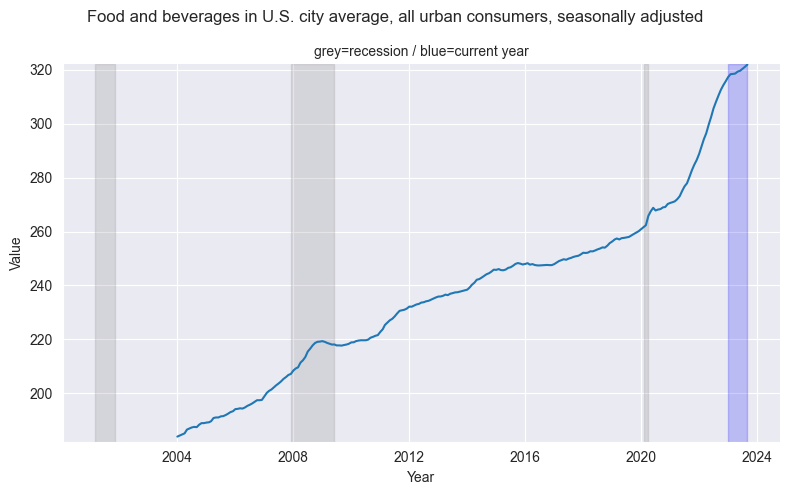

In [9]:
plot_bls_series_id(
    series_id='CUSR0000SAF',
    series_descr='Food and beverages in U.S. city average, all urban consumers, seasonally adjusted',
    bls_key=bls_key
)

#### CPI for Commodities less food, energy, and used cars and trucks in U.S. city average, all urban consumers, seasonally adjusted

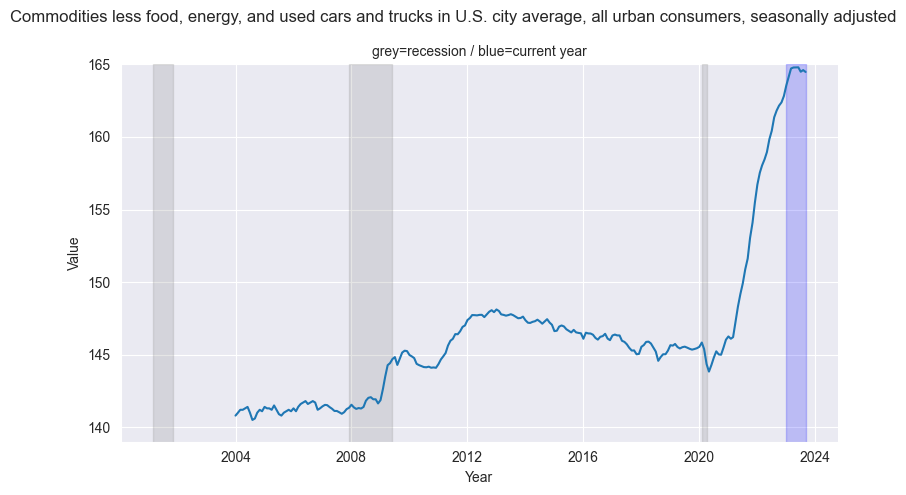

In [10]:
plot_bls_series_id(
    series_id='CUSR0000SACL1E4',
    series_descr='Commodities less food, energy, and used cars and trucks in U.S. city average, all urban consumers, seasonally adjusted',
    bls_key=bls_key
)

Examples of commodities less food, beverages, and used cars and trucks in the context of the U.S. city average, all urban consumers, seasonally adjusted, can include:

- Clothing: This category encompasses clothing and apparel items such as shirts, pants, dresses, shoes, and accessories.
- Electronics: This category includes products like televisions, computers, smartphones, and other electronic gadgets.
- Furniture: This category comprises items like sofas, chairs, tables, and other home furnishings.
- Household goods: This can include products like cleaning supplies, kitchenware, and various household items.
- Personal care products: Items such as toiletries, cosmetics, and personal hygiene products fall under this category.
- Appliances: This includes large and small appliances like refrigerators, washing machines, and microwaves.
- Tools and equipment: Items for home improvement, gardening, and various tools would be in this category.
- Office supplies: Products like paper, pens, and office equipment.
- Home decor: Items like curtains, rugs, and decorative items for the home.
- Pet supplies: Products for pet care, such as pet food, toys, and accessories.

#### CPI for Energy commodities in U.S. city average, all urban consumers, seasonally adjusted

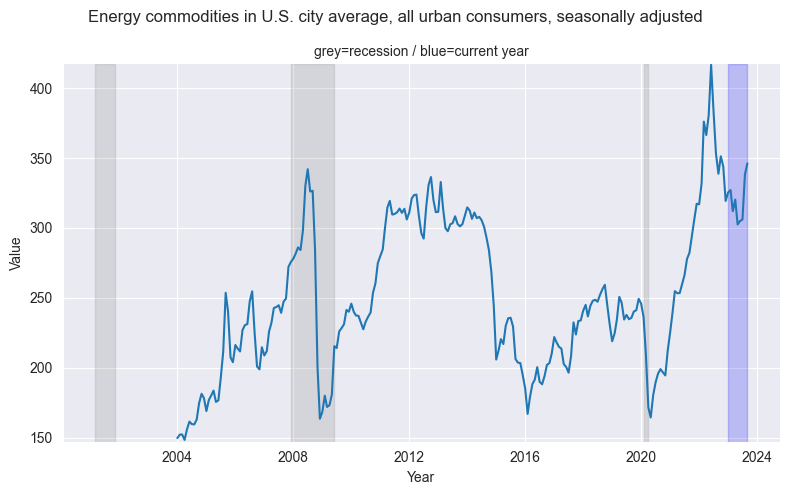

In [11]:
plot_bls_series_id(
    series_id='CUSR0000SACE',
    series_descr='Energy commodities in U.S. city average, all urban consumers, seasonally adjusted',
    bls_key=bls_key
)

#### CPI for Gasoline, unleaded regular in U.S. city average, all urban consumers, seasonally adjusted

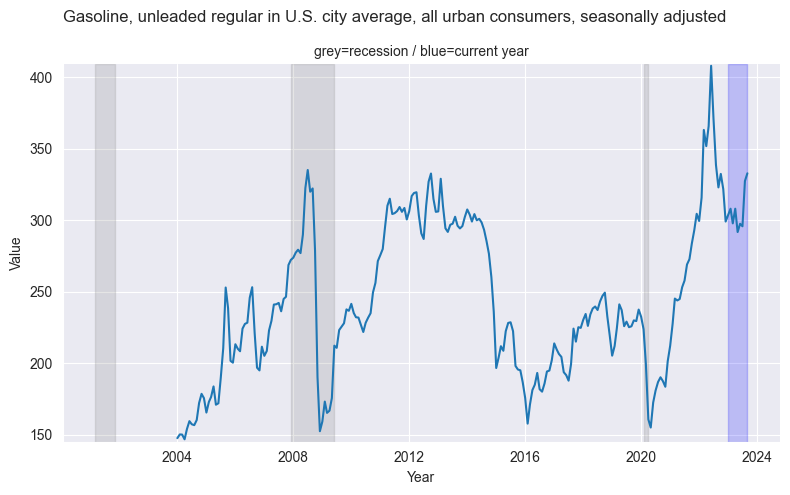

In [12]:
plot_bls_series_id(
    series_id='CUSR0000SS47014',
    series_descr='Gasoline, unleaded regular in U.S. city average, all urban consumers, seasonally adjusted',
    bls_key=bls_key
)

#### Number of All employees, thousands, professional and business services, seasonally adjusted 

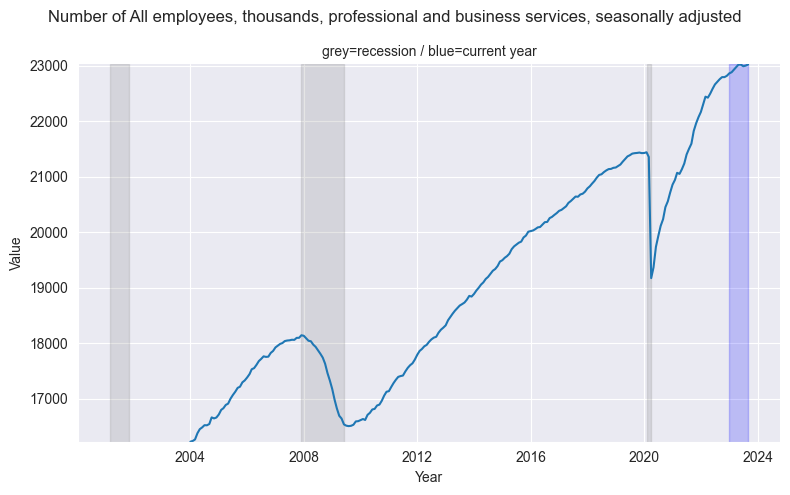

In [13]:
plot_bls_series_id(
    series_id='CES6000000001',
    series_descr='Number of All employees, thousands, professional and business services, seasonally adjusted',
    bls_key=bls_key
)

#### Same as above, but let's just plot last 3 years of data

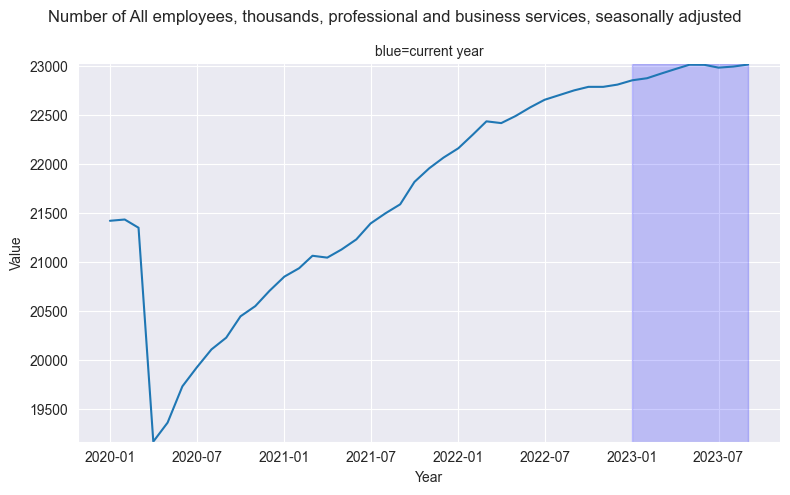

In [14]:
plot_bls_series_id(
    series_id='CES6000000001',
    series_descr='Number of All employees, thousands, professional and business services, seasonally adjusted',
    bls_key=bls_key,
    past_n_years=3
)

From above, we see that hiring has slowed significantly during summer of 2023 and has picked up slightly in last couple of months.